In [2]:
from Lib.class_Vs_profile import Vs_Profile
from Lib.class_ground_motion import Ground_Motion
from Lib.class_hh_calibration import HH_Calibration
from Lib.class_damping_calibration import Damping_Calibration
from Lib.class_simulation import Nonlinear_Simulation
from Lib.class_batch_simulation import Batch_Simulation
from Numpy_txt import read_file
import numpy as np

In [1]:
from pandas import read_excel

excel = read_excel('soil_generations.xlsx',sheet_name='Vs150')
print(excel.iloc[1,:].vs1)

100


In [3]:
def create_profile(row):
    return np.array([
        [10,row.vs1,0.05,1800,1],
        [10,row.vs2,0.05,1800,2],
        [10,row.vs3,0.05,1800,3],
        [0,2000,0.05,1800,0],
    ])

In [4]:
len(excel)

6

In [5]:

vs_profile = Vs_Profile(create_profile(excel.iloc[0,:]))

In [10]:
import os
folder = 'files\low'
input_accels = []
for f in os.listdir(folder):
    acc,dt = read_file(os.path.join(folder,f))
    input_accel = Ground_Motion(acc,dt=dt, unit='cm/s/s')
    input_accels.append(input_accel)


----------+----------+-------------+------------------+--------------
  Thk [m] | Vs [m/s] | Damping [%] | Density [kg/m^3] | Material No. 
----------+----------+-------------+------------------+--------------
  10.00   |  100.0   |    5.000    |      1800.0      |      1       
  10.00   |  150.0   |    5.000    |      1800.0      |      2       
  10.00   |  200.0   |    5.000    |      1800.0      |      3       
   0.00   |  2000.0  |    5.000    |      1800.0      |      0       
----------+----------+-------------+------------------+--------------

(Vs30 = 138.5 m/s)



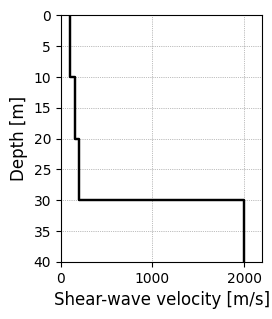

In [11]:
vs_profile.summary()

In [12]:
hh_c = HH_Calibration(vs_profile)
hh_g_param = hh_c.fit()

========== Start optimizing for HH_G parameters ===========
------ G/Gmax not provided; will generate MKZ curves using Darendeli (2001): ------
-----------  FKZ optimization  -----------------------------
1/3: mu = 0.640, a = 100.0, gamma_t = 0.011%, d = 0.978
2/3: mu = 0.537, a = 100.0, gamma_t = 0.040%, d = 0.978
3/3: mu = 0.414, a = 100.0, gamma_t = 0.061%, d = 0.941


In [13]:
d_c = Damping_Calibration(vs_profile)
hh_x_param = d_c.get_HH_x_param(
    parallel=True,  # set `parallel` to `True` to use multiple CPU cores
    pop_size=200, 
    n_gen=100,  # pop_size and n_gen control the speed and accuracy of the fit
    show_fig=False,
)

In [14]:
nl_sim = Nonlinear_Simulation(vs_profile, input_accel, G_param=hh_g_param, xi_param=hh_x_param, boundary='rigid')

In [15]:
batch_nonl_sim = Batch_Simulation([Nonlinear_Simulation(vs_profile, acc, G_param=hh_g_param, xi_param=hh_x_param, boundary='rigid') for acc in input_accels])

In [16]:
sim_results = batch_nonl_sim.run(
    parallel=True,
    n_cores=5
)

Parallel computing in progress... done.


In [17]:
acc = sim_results[0].accel_on_surface.accel

In [18]:
sim_results[0].accel_on_surface.pga_in_g

0.0003485453618756371

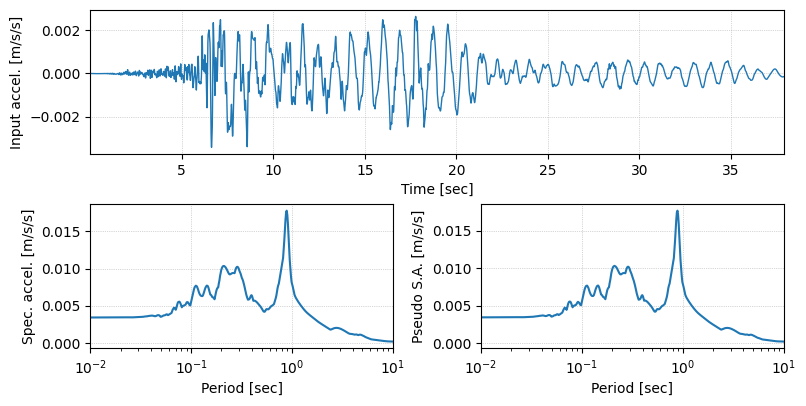

In [20]:
from Lib.helper_site_response import response_spectra

rs = response_spectra(acc,0.01,10,500,show_fig=True)

In [21]:
periods,sa,_,_,_,_,_ = rs

print(sa/9.81)
print(periods)

[3.48546878e-04 3.48563971e-04 3.48581735e-04 3.48599479e-04
 3.48617522e-04 3.48636810e-04 3.48657165e-04 3.48677333e-04
 3.48696759e-04 3.48716764e-04 3.48737319e-04 3.48756938e-04
 3.48776410e-04 3.48797076e-04 3.48817645e-04 3.48836916e-04
 3.48855520e-04 3.48874826e-04 3.48895237e-04 3.48915015e-04
 3.48934029e-04 3.48956454e-04 3.48985436e-04 3.49017167e-04
 3.49047850e-04 3.49080956e-04 3.49119657e-04 3.49160814e-04
 3.49199788e-04 3.49235920e-04 3.49271567e-04 3.49308950e-04
 3.49348572e-04 3.49385004e-04 3.49409636e-04 3.49424532e-04
 3.49443496e-04 3.49472235e-04 3.49497430e-04 3.49505008e-04
 3.49502779e-04 3.49513484e-04 3.49547158e-04 3.49591728e-04
 3.49633231e-04 3.49671160e-04 3.49711394e-04 3.49758753e-04
 3.49817909e-04 3.49892590e-04 3.49974078e-04 3.50040672e-04
 3.50089676e-04 3.50150376e-04 3.50247164e-04 3.50370229e-04
 3.50490550e-04 3.50596463e-04 3.50704494e-04 3.50822425e-04
 3.50933982e-04 3.51038489e-04 3.51166198e-04 3.51318040e-04
 3.51425436e-04 3.514181